In [3]:
import torch.nn.functional as F
from flood_forecast.transformer_xl.attn import FullAttention, ProbAttention, AttentionLayer
from flood_forecast.transformer_xl.data_embedding import DataEmbedding
from flood_forecast.transformer_xl.informer import Informer


import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)

        self.x = df[['전류(A)', '누적_용량(Ah)', '절대값_용량(Ah)']].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

        self.y = df.iloc[:, 7:8].values
        
        self.length = len(df)

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [5]:
dataset = CustomDataset("180801_RFB_510cy_006_DC_20000.csv")
print(dataset.x.shape)
print(dataset.x.dtype)
print(dataset.y.shape)
print(dataset.y.dtype)

(20000, 3)
float64
(20000, 1)
float64


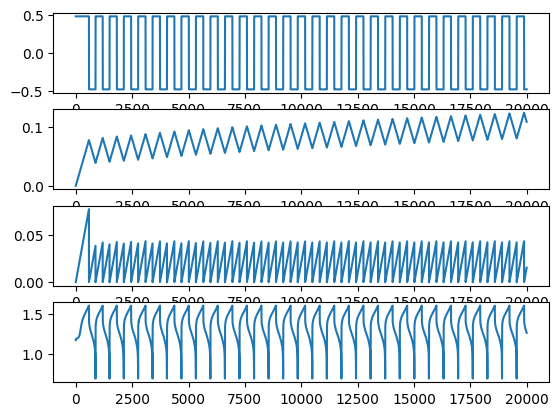

In [6]:

plt.subplot(4,1,1)
plt.plot(dataset.x[:20000,:1].squeeze())
plt.subplot(4,1,2)
plt.plot(dataset.x[:20000,1:2].squeeze())
plt.subplot(4,1,3)
plt.plot(dataset.x[:20000,2:3].squeeze())
plt.subplot(4,1,4)
plt.plot(dataset.y[:20000].squeeze())
plt.show()

In [7]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 16000
Validation Data Size : 2000
Testing Data Size : 2000


In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False, drop_last=True, num_workers=4)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False, drop_last=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True, num_workers=4)

In [9]:
num_epochs = 10
learning_rate = 0.001

# input_size = 3
# hidden_size = 16
# num_layers = 1

# num_classes = 1
n_time_series = 3
dec_in = 4
c_out = 1
seq_len = 16
label_len = 4
out_len = 4

model = Informer(n_time_series, dec_in, c_out, seq_len, label_len, out_len)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def train_loop(model, dataloader, loss_func, optimizer):
    model.train()
    size = len(dataloader.dataset)
    print("Training")
    running_loss = 0.
    last_loss = 0.

    for batch, (x,y) in tqdm(enumerate(dataloader)):
        print("4")
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = loss_func(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [11]:
def test_loop(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(model, train_dataloader, loss_func, optimizer)
    test_loop(model, test_dataloader, loss_func)
print("Done!")

Epoch 1
-------------------------------
Training


In [ ]:
X = torch.Tensor(dataset.x)
X1 = torch.reshape(X, (X.shape[0], 1, X.shape[1]))
X1 = X1.to(device)

Y = torch.Tensor(dataset.y)

train_predict = model(X1)

train_predict = train_predict.to('cpu')
predicted = train_predict.data.numpy()
label_y = Y.data.numpy()

plt.figure(figsize=(10,6))
plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Voltage prediction')
plt.legend()
plt.show()